In [1]:
!pip install tensorflow 

In [2]:
import tensorflow as tf
print(tf.__version__)
     


2.17.0


In [3]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os
from tensorflow.keras.applications import MobileNetV2
# Fix the seeds
SEED = 666
tf.random.set_seed(SEED)
np.random.seed(SEED) 

In [4]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
) 

# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"] 

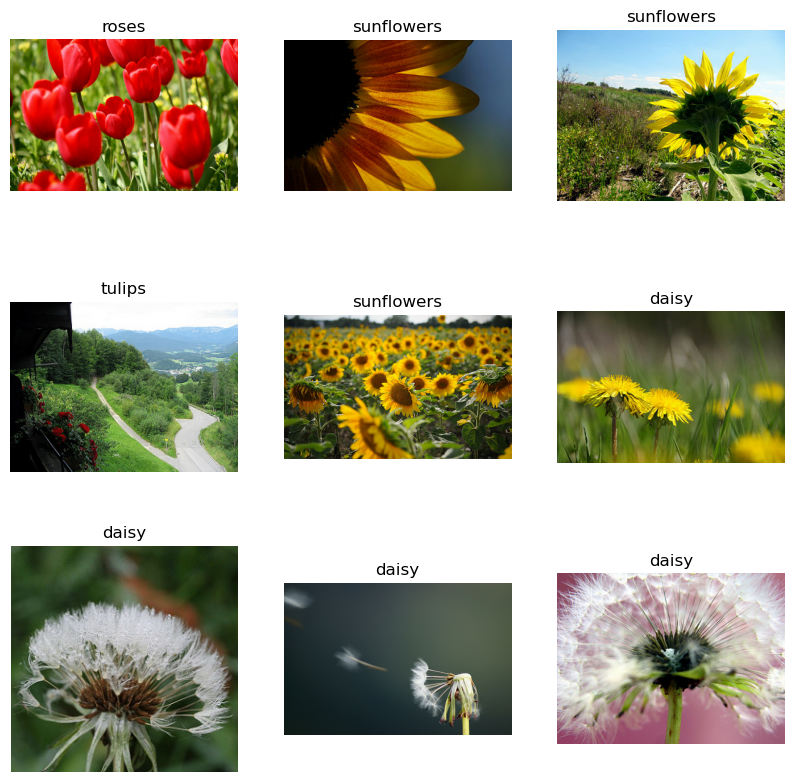

In [5]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")
     

In [6]:
# MODEL PREPERATION 

In [7]:
SIZE = (224, 224)

def preprocess_image(image, label):
    # image = tf.image.convert_image_dtype(image, tf.float32)
    # The model includes the normalization steps
    image = tf.image.resize(image, SIZE)
    return (image, label) 

In [8]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
) 

In [9]:
def get_training_model(base_model):
    inputs = Input(shape=(224, 224, 3), name="image") 
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show() 

In [10]:
base_model = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224 ,3))
base_model.trainable = True

get_training_model(base_model).summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) 

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 779s 15s/step - accuracy: 0.3218 - loss: 1.5989 - val_accuracy: 0.3491 - val_loss: 1.5748
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 886s 17s/step - accuracy: 0.7059 - loss: 0.9046 - val_accuracy: 0.5182 - val_loss: 1.2112
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 673s 14s/step - accuracy: 0.8406 - loss: 0.6078 - val_accuracy: 0.6182 - val_loss: 0.9953
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 671s 14s/step - accuracy: 0.8803 - loss: 0.4767 - val_accuracy: 0.6673 - val_loss: 0.8418
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 663s 14s/step - accuracy: 0.8933 - loss: 0.3760 - val_accuracy: 0.7055 - val_loss: 0.7381
Total training time (seconds):  3671.621271133423


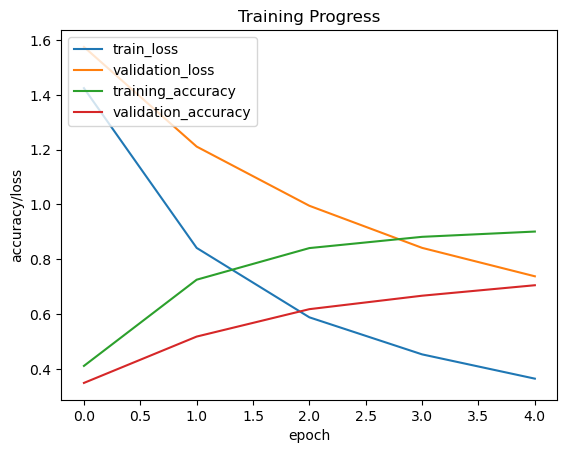

In [12]:
start = time.time()
model_mnv2 = get_training_model(base_model)
model_mnv2.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
h = model_mnv2.fit(train_ds,
                  validation_data=validation_ds,
                  epochs=5)
print("Total training time (seconds): ",time.time()-start)
plot_progress(h) 

In [16]:
def plot_predictions(images, labels, probability):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        predicted_label = CLASSES[np.argmax(probability[i])]
        maximum_probability = "{:.3f}".format(max(probability[i]))
        text = "{} with probability: {}".format(predicted_label, maximum_probability) + \
            "\nGround-truth: {}".format(CLASSES[int(labels[i])])
        plt.title(text)
        plt.axis("off")
    plt.show() 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


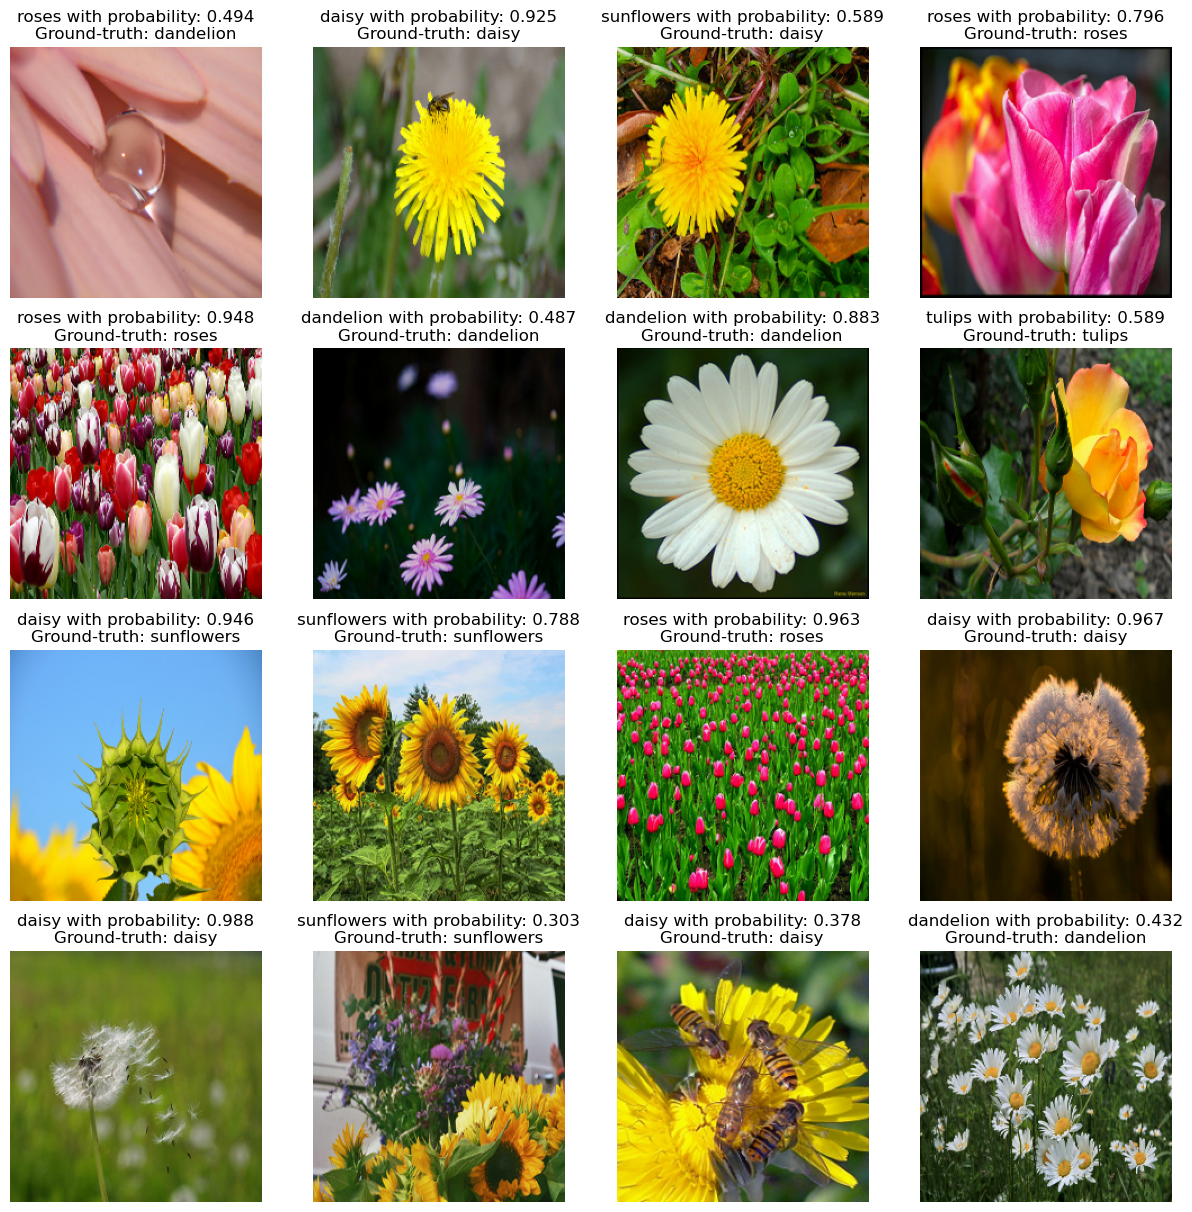

In [17]:
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = model_mnv2.predict(batch_images)
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])         

In [20]:
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    batch_labels[-1],
    predictions[-1]
)
print("Crossentropy loss: ",loss.numpy())

# The probability we got when we ran the inference
print("Class probability: ",np.exp(-loss.numpy())) 

Crossentropy loss:  0.3883282
Class probability:  0.6781897


In [ ]:
#Creating Adversarial 

In [22]:
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS) 

In [23]:
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255.
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta 

In [24]:
def perturb_image(model, image, true, target):
    print("Before adversarial attack")
    preprocessed_image = image/255.
    probabilities = model.predict(preprocessed_image)
    class_index = np.argmax(probabilities)
    print("Ground-truth label: {} predicted label: {}".format(CLASSES[true], CLASSES[class_index]))
    
    # Initialize the perturbation quantity
    image_tensor = tf.constant(image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255.
    print("After adversarial attack")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))
    cv2.imwrite("perturbed_image.png", perturbed_image.numpy().squeeze())
     

In [26]:
index = 15
sample_val_image = batch_images[index].numpy()
sample_val_image = np.expand_dims(sample_val_image, 0)
     
     

Before adversarial attack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Ground-truth label: dandelion predicted label: daisy
0 0.67157507
20 0.6436801
40 0.61367226
60 0.583858
80 0.5549936
100 0.52739525
120 0.5005598
140 0.47472143
160 0.44896603
180 0.4240446
200 0.40017986
220 0.37755585
240 0.35544634
260 0.33418703
280 0.31340075
300 0.29286528
320 0.27293158
340 0.25344515


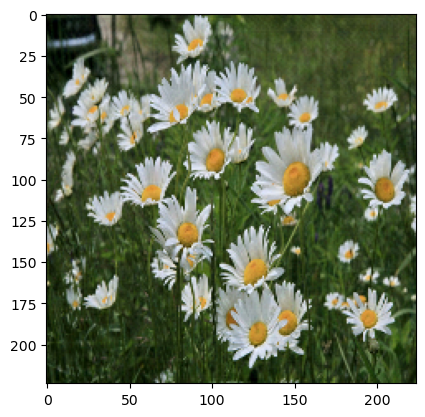

After adversarial attack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted label: daisy


In [28]:
perturb_image(model_mnv2, sample_val_image, batch_labels[index].numpy(), 4) 